# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

#### Assignment is Completed by Kiran Pittampally and Keval R Menon

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [180]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import keras_tuner as kt
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [181]:
# Define a function to load data and aggregate them

def aggregate_stock_data(file_paths):
    data_frames = []
    for path in file_paths:
        stock_data = pd.read_csv(path)
        data_frames.append(stock_data)
    aggregated_data = pd.concat(data_frames, axis=0)
    return aggregated_data




In [182]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files

data_files = [
    'RNN_Stocks_Data/AMZN_stocks_data.csv',
    'RNN_Stocks_Data/GOOGL_stocks_data.csv',
    'RNN_Stocks_Data/IBM_stocks_data.csv',
    'RNN_Stocks_Data/MSFT_stocks_data.csv'
]
# Load and combine data
stock_data_combined = aggregate_stock_data(data_files)



In [183]:
# Ensure 'Date' is in datetime format
stock_data_combined['Date'] = pd.to_datetime(stock_data_combined['Date'])

In [184]:
# View specifics of the data
stock_data_combined.head()


Date   Open   High    Low  Close   Volume  Name
0 2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN
1 2006-01-04  47.48  47.73  46.69  47.25  7440914  AMZN
2 2006-01-05  47.16  48.20  47.11  47.65  5417258  AMZN
3 2006-01-06  47.97  48.58  47.32  47.87  6154285  AMZN
4 2006-01-09  46.55  47.10  46.40  47.08  8945056  AMZN

In [185]:
stock_data_combined.info()  # Check the data types and null values
stock_data_combined.describe()  # Get a summary of the data

<class 'pandas.core.frame.DataFrame'>
Index: 12077 entries, 0 to 3018
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    12077 non-null  datetime64[ns]
 1   Open    12076 non-null  float64       
 2   High    12077 non-null  float64       
 3   Low     12076 non-null  float64       
 4   Close   12077 non-null  float64       
 5   Volume  12077 non-null  int64         
 6   Name    12077 non-null  object        
dtypes: datetime64[ns](1), float64(4), int64(1), object(1)
memory usage: 754.8+ KB


Date          Open          High  \
count                          12077  12076.000000  12077.000000   
mean   2012-01-01 18:44:08.803510784    227.387118    229.422254   
min              2006-01-03 00:00:00     15.200000     15.620000   
25%              2008-12-31 00:00:00     54.930000     55.660000   
50%              2011-12-30 00:00:00    158.795000    160.410000   
75%              2015-01-02 00:00:00    281.405000    284.500000   
max              2017-12-29 00:00:00   1204.880000   1213.410000   
std                              NaN    236.938260    238.568485   

                Low         Close        Volume  
count  12076.000000  12077.000000  1.207700e+04  
mean     225.203189    227.380960  1.671763e+07  
min       14.870000     15.150000  2.542560e+05  
25%       54.425000     55.210000  3.124704e+06  
50%      157.355000    158.880000  5.445269e+06  
75%      278.610000    281.510000  1.802087e+07  
max     1191.150000   1195.830000  5.910786e+08  
std      234.981015    236.851101  2.570572e+07

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [186]:
# Handle Missing Values

#Before handling missing values, let's check for any null values in the dataset.
missing_values = stock_data_combined.isnull().sum()
print("Missing values in each column:")
print(missing_values)

# Drop rows with missing values
stock_data_combined.dropna(inplace=True)
# Check again for missing values
missing_values_after = stock_data_combined.isnull().sum()
print("Missing values after dropping rows:")
print(missing_values_after)

Missing values in each column:
Date      0
Open      1
High      0
Low       1
Close     0
Volume    0
Name      0
dtype: int64
Missing values after dropping rows:
Date      0
Open      0
High      0
Low       0
Close     0
Volume    0
Name      0
dtype: int64


### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

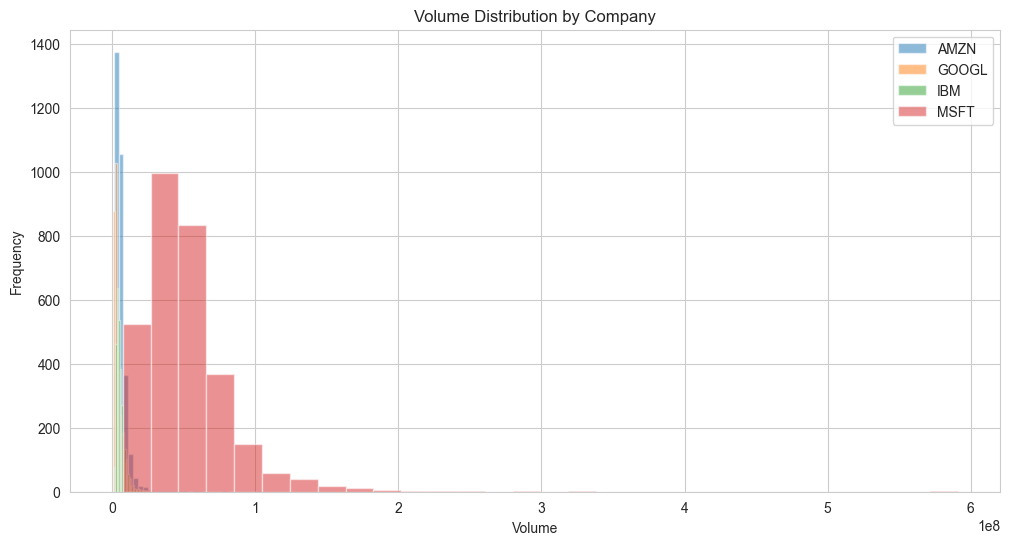

In [187]:
# Frequency distribution of volumes

df = stock_data_combined.copy()
company_names = df['Name'].unique()
# Set the figure size
plt.figure(figsize=(12, 6))
# Create a histogram for each company
for company in company_names:
    plt.hist(df[df['Name'] == company]['Volume'], bins=30, alpha=0.5, label=company)
plt.title('Volume Distribution by Company')
plt.xlabel('Volume')
plt.ylabel('Frequency')
plt.legend()
plt.show()



In [188]:
# Stock volume variation over time
plt.figure(figsize=(15, 10))
sns.set_style('whitegrid')
plt.title('Stock Volumes Over Time', fontsize=18)
for company in company_names:
    sns.lineplot(data=df[df['Name'] == company], x='Date', y='Volume', label=company)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Volume', fontsize=14)
plt.legend(title='Company', fontsize=12)
plt.show()



#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

In [189]:
# Analyse correlations

# Dropping the 'Name' column as it's non-numeric and irrelevant for correlation analysis
#df_numeric = stock_data_combined.drop(columns=['Name'])

correlation_matrix = stock_data_combined.select_dtypes(include=[np.number]).corr()

# Plotting the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f', linewidths=0.5)
plt.title('Correlation Heatmap of Stock Data')
plt.tight_layout()
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [190]:
# Define a function that divides the data into windows and generates target variable values for each window

def create_windowed_variables(df, window_size=65, step_size=5, target_column='Close'):
    """
    Creates windowed data (X), corresponding target variable (y), and the stock Name.
    """
    # Ensure the data is sorted by 'Date'
    df = df.sort_values(by='Date').reset_index(drop=True)
    
    # Prepare lists to store results
    X, y, stock_names = [], [], []
    
    # Iterate through the data to create windows
    for start_idx in range(0, len(df) - window_size, step_size):
        end_idx = start_idx + window_size
        
        # Extract the window and target
        window_data = df.iloc[start_idx:end_idx]
        target_value = df[target_column].iloc[end_idx]
        stock_name = df['Name'].iloc[end_idx]
        
        # Append results
        X.append(window_data.drop(columns=['Date', 'Name', target_column]).values)
        y.append(target_value)
        stock_names.append(stock_name)
    
    # Convert lists to numpy arrays
    return np.array(X), np.array(y), np.array(stock_names)



#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [191]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def scale_windowed_data(X, y):
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    # partial_fit on X
    for i in range(X.shape[0]):
        scaler_X.partial_fit(X[i])

    X_scaled = []
    for i in range(X.shape[0]):
        X_scaled.append(scaler_X.transform(X[i]))
    
    X_scaled = np.array(X_scaled)

    # Scale y
    y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).reshape(-1)

    return X_scaled, y_scaled, scaler_X, scaler_y 

Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [192]:
# Define a function to create input and output data points from the master DataFrame

from collections import defaultdict

# Define a function to create input and output data points from the master DataFrame

def split_train_test(X, y, stock_names, test_size=0.2, random_state=42):
    """
    Splits X and y into training and testing sets, keeping stock names aligned.

    Args:
    - X: Numpy array of features
    - y: Numpy array of targets
    - stock_names: Numpy array of stock names
    - test_size: Fraction of the data to be used as test set
    - random_state: Random seed for reproducibility

    Returns:
    - Dictionary with stock name as key and (X_train, X_test, y_train, y_test) as value
    """
    results = defaultdict(list)
   
    for stock in np.unique(stock_names):
        # Filter data for this stock
        mask = stock_names == stock
        X_stock, y_stock = X[mask], y[mask]

        # Perform train-test split
        X_train, X_test, y_train, y_test = train_test_split(
            X_stock, y_stock, test_size=test_size, random_state=random_state
        )

        results[stock] = (X_train, X_test, y_train, y_test)

    return dict(results)




We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

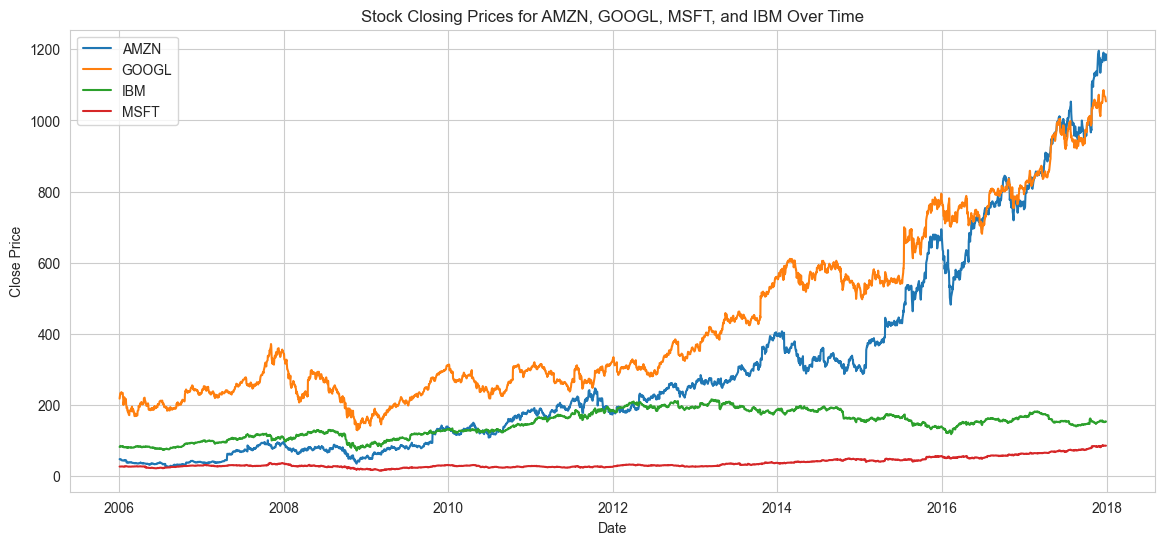

In [193]:
# Checking for patterns in different sequence lengths

plt.figure(figsize=(14, 6))

# Iterate through the list of stocks and plot their closing prices
for stock in np.unique(stock_data_combined['Name']):
    stock_data = stock_data_combined[stock_data_combined['Name'] == stock]
    plt.plot(stock_data['Date'], stock_data['Close'], label=stock)

plt.title('Stock Closing Prices for AMZN, GOOGL, MSFT, and IBM Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.grid(True)
plt.show()


In [194]:
# Create subplots to show closing prices for different stocks for 1 week, 1 month, and 1 quarter
fig, axes = plt.subplots(3, 1, figsize=(14, 18))

time_periods = {
    "1 Week": 5,
    "1 Month": 20,
    "1 Quarter": 65
}

for ax, (label, days) in zip(axes, time_periods.items()):
    for stock in np.unique(stock_data_combined['Name']):
        stock_data = stock_data_combined[stock_data_combined['Name'] == stock]
        ax.plot(stock_data['Date'], stock_data['Close'], label=stock)
    ax.set_title(f'Stock Closing Prices for {label}')
    ax.set_xlabel('Date')
    ax.set_ylabel('Close Price')
    ax.legend()
    ax.grid(True)
    ax.set_xlim([stock_data_combined['Date'].min(), stock_data_combined['Date'].min() + pd.Timedelta(days=days)])

plt.tight_layout()
plt.show()

### Out of 5,20,65 business days, 65 days timewindow is showing up clear trend without noise

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [195]:
stock_data_combined.head(1)

Date   Open   High    Low  Close   Volume  Name
0 2006-01-03  47.47  47.85  46.25  47.58  7582127  AMZN

In [196]:
# Create a pipeline
def prepare_data_pipeline(combined_data, target_names, window_size=65, step_size=5, test_size=0.2):
    """
    Prepares the windowed, scaled, and split data for multiple stocks together.

    Returns:
    - X_train, y_train, stock_train
    - X_test, y_test, stock_test
    """

    # Prepare lists to store data for all stocks
    X_all, y_all, stock_all = [], [], []

    for stock in target_names:
        # Filter data for the current stock
        stock_df = combined_data[combined_data['Name'] == stock]
        
        # Create windowed variables
        X_stock, y_stock, _ = create_windowed_variables(
            stock_df, 
            window_size=window_size, 
            step_size=step_size, 
            target_column='Close'
        )
        
        # Append data for the current stock
        X_all.append(X_stock)
        y_all.append(y_stock)
        stock_all.extend([stock] * len(X_stock))

    # Combine data from all stocks
    X_all = np.vstack(X_all)
    y_all = np.hstack(y_all)
    stock_all = np.array(stock_all)
    
    # Scale the data
    X_all_scaled, y_all_scaled, scaler_X, scaler_y = scale_windowed_data(X_all, y_all)
    
    # Perform train-test split
    X_train, X_test, y_train, y_test, stock_train, stock_test = train_test_split(
        X_all_scaled, y_all_scaled, stock_all, test_size=test_size, random_state=42, shuffle=True
    )
    
    return X_train, X_test, y_train, y_test, stock_train, stock_test, scaler_X, scaler_y

In [197]:
# Create data instances from the master data frame using decided window size and window stride

# Prepare the data from combined_data
X_train, X_test, y_train, y_test, stock_train, stock_test, scaler_X, scaler_y = prepare_data_pipeline(
    stock_data_combined, 
    ['AMZN', 'GOOGL', 'IBM', 'MSFT'], 
    window_size=65, 
    step_size=5, 
    test_size=0.2
)

In [198]:
# Check the number of data points generated
shapes = {
    "X_train": X_train.shape,
    "y_train": y_train.shape,
    "stock_train": stock_train.shape,
    "X_test": X_test.shape,
    "y_test": y_test.shape
}

for key, value in shapes.items():
    print(f"{key} shape: {value}")


X_train shape: (1891, 65, 4)
y_train shape: (1891,)
stock_train shape: (1891,)
X_test shape: (473, 65, 4)
y_test shape: (473,)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [199]:
# Check if the datasets are compatible inputs to neural networks
# Check the shapes of the datasets
print(f"X_train shape: {X_train.shape}")  # Should be (samples, timesteps, features)
print(f"y_train shape: {y_train.shape}")  # Should be (samples,)
print(f"X_test shape: {X_test.shape}")    # Should be (samples, timesteps, features)
print(f"y_test shape: {y_test.shape}")    # Should be (samples,)

# Check if the number of samples in X and y match
assert X_train.shape[0] == y_train.shape[0], "Mismatch in number of samples between X_train and y_train"
assert X_test.shape[0] == y_test.shape[0], "Mismatch in number of samples between X_test and y_test"

# Check if the input data has the correct number of timesteps and features
print(f"Number of timesteps in X_train: {X_train.shape[1]}")
print(f"Number of features in X_train: {X_train.shape[2]}")

X_train shape: (1891, 65, 4)
y_train shape: (1891,)
X_test shape: (473, 65, 4)
y_test shape: (473,)
Number of timesteps in X_train: 65
Number of features in X_train: 4


## **2 RNN Models** <font color =red> [20 marks] </font>

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [200]:
# Create a function that creates a simple RNN model according to the model configuration arguments

def build_model(hp, model_type='SimpleRNN', input_shape=(65, 4)):
    model = Sequential()

    # Add Input layer
    model.add(Input(shape=input_shape))

    # Add RNN layers
    for i in range(hp.Int('num_layers', 1, 3)):  # Tune between 1 to 3 layers
        units = hp.Int(f'units_layer_{i}', min_value=32, max_value=256, step=32)
        return_sequences = i < hp.get('num_layers') - 1  # True for intermediate layers

        if model_type == 'SimpleRNN':
            model.add(SimpleRNN(units=units, activation='tanh', return_sequences=return_sequences))
        elif model_type == 'LSTM':
            model.add(LSTM(units=units, activation='tanh', return_sequences=return_sequences))
        elif model_type == 'GRU':
            model.add(GRU(units=units, activation='tanh', return_sequences=return_sequences))

        model.add(Dropout(hp.Float(f'dropout_layer_{i}', 0.1, 0.5, step=0.1)))

    # Add output layer
    model.add(Dense(1))

    # Compile the model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='mse',
        metrics=['mae']
    )

    return model



#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [201]:
# Find an optimal configuration of simple RNN

tuner = kt.RandomSearch(
    lambda hp: build_model(hp, model_type='SimpleRNN', input_shape=(X_train.shape[1], X_train.shape[2])),  # Pass the model-building function
    objective='val_loss',  # Optimize for validation loss
    max_trials=20,  # Number of different hyperparameter combinations to try
    executions_per_trial=2,  # Number of models to train per combination
    directory='rnn_tuning_final',  # Directory to save tuning results
    project_name='final_rnn_search'  # Name of the tuning project
)

# Configure the EarlyStopping callback to stop training when validation loss stops improving
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore the weights of the best model
)



Reloading Tuner from rnn_tuning_final\final_rnn_search\tuner0.json


In [202]:
#

In [203]:
# Find the best configuration based on evaluation metrics

tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameters
print("\nBest Hyperparameters:")
num_layers = best_hps.get('num_layers')
print(f"Number of Layers: {num_layers}")
for layer in range(num_layers):
    units = best_hps.get(f'units_layer_{layer}')
    dropout = best_hps.get(f'dropout_layer_{layer}')
    print(f"  Layer {layer + 1} - Units: {units}, Dropout: {dropout}")
learning_rate = best_hps.get('learning_rate')
print(f"Learning Rate: {learning_rate}")



Best Hyperparameters:
Number of Layers: 1
  Layer 1 - Units: 224, Dropout: 0.4
Learning Rate: 0.001


#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [204]:
#

In [205]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model

simple_model = tuner.hypermodel.build(best_hps)



# Display the model architecture
simple_model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 224)            │        51,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,521 (201.25 KB)

 Trainable params: 51,521 (201.25 KB)

 Non-trainable params: 0 (0.00 B)

In [206]:
history = simple_model.fit(
    X_train, y_train,
    epochs=50,
    validation_split=0.2,  # Use 20% of the training data for validation
    batch_size=32,
    callbacks=[early_stopping],
    verbose=2
)


plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()


Epoch 1/50
48/48 - 3s - 60ms/step - loss: 0.1112 - mae: 0.2252 - val_loss: 0.0061 - val_mae: 0.0571
Epoch 2/50
48/48 - 1s - 24ms/step - loss: 0.0403 - mae: 0.1382 - val_loss: 0.0052 - val_mae: 0.0505
Epoch 3/50
48/48 - 2s - 32ms/step - loss: 0.0312 - mae: 0.1188 - val_loss: 0.0052 - val_mae: 0.0506
Epoch 4/50
48/48 - 1s - 28ms/step - loss: 0.0203 - mae: 0.0937 - val_loss: 0.0171 - val_mae: 0.0939
Epoch 5/50
48/48 - 2s - 33ms/step - loss: 0.0209 - mae: 0.0935 - val_loss: 0.0044 - val_mae: 0.0490
Epoch 6/50
48/48 - 1s - 31ms/step - loss: 0.0176 - mae: 0.0856 - val_loss: 0.0024 - val_mae: 0.0305
Epoch 7/50
48/48 - 1s - 30ms/step - loss: 0.0178 - mae: 0.0851 - val_loss: 0.0024 - val_mae: 0.0329
Epoch 8/50
48/48 - 1s - 28ms/step - loss: 0.0138 - mae: 0.0745 - val_loss: 0.0016 - val_mae: 0.0260
Epoch 9/50
48/48 - 1s - 23ms/step - loss: 0.0101 - mae: 0.0671 - val_loss: 0.0011 - val_mae: 0.0221
Epoch 10/50
48/48 - 1s - 31ms/step - loss: 0.0090 - mae: 0.0627 - val_loss: 0.0017 - val_mae: 0.0282

Plotting the actual vs predicted values

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step


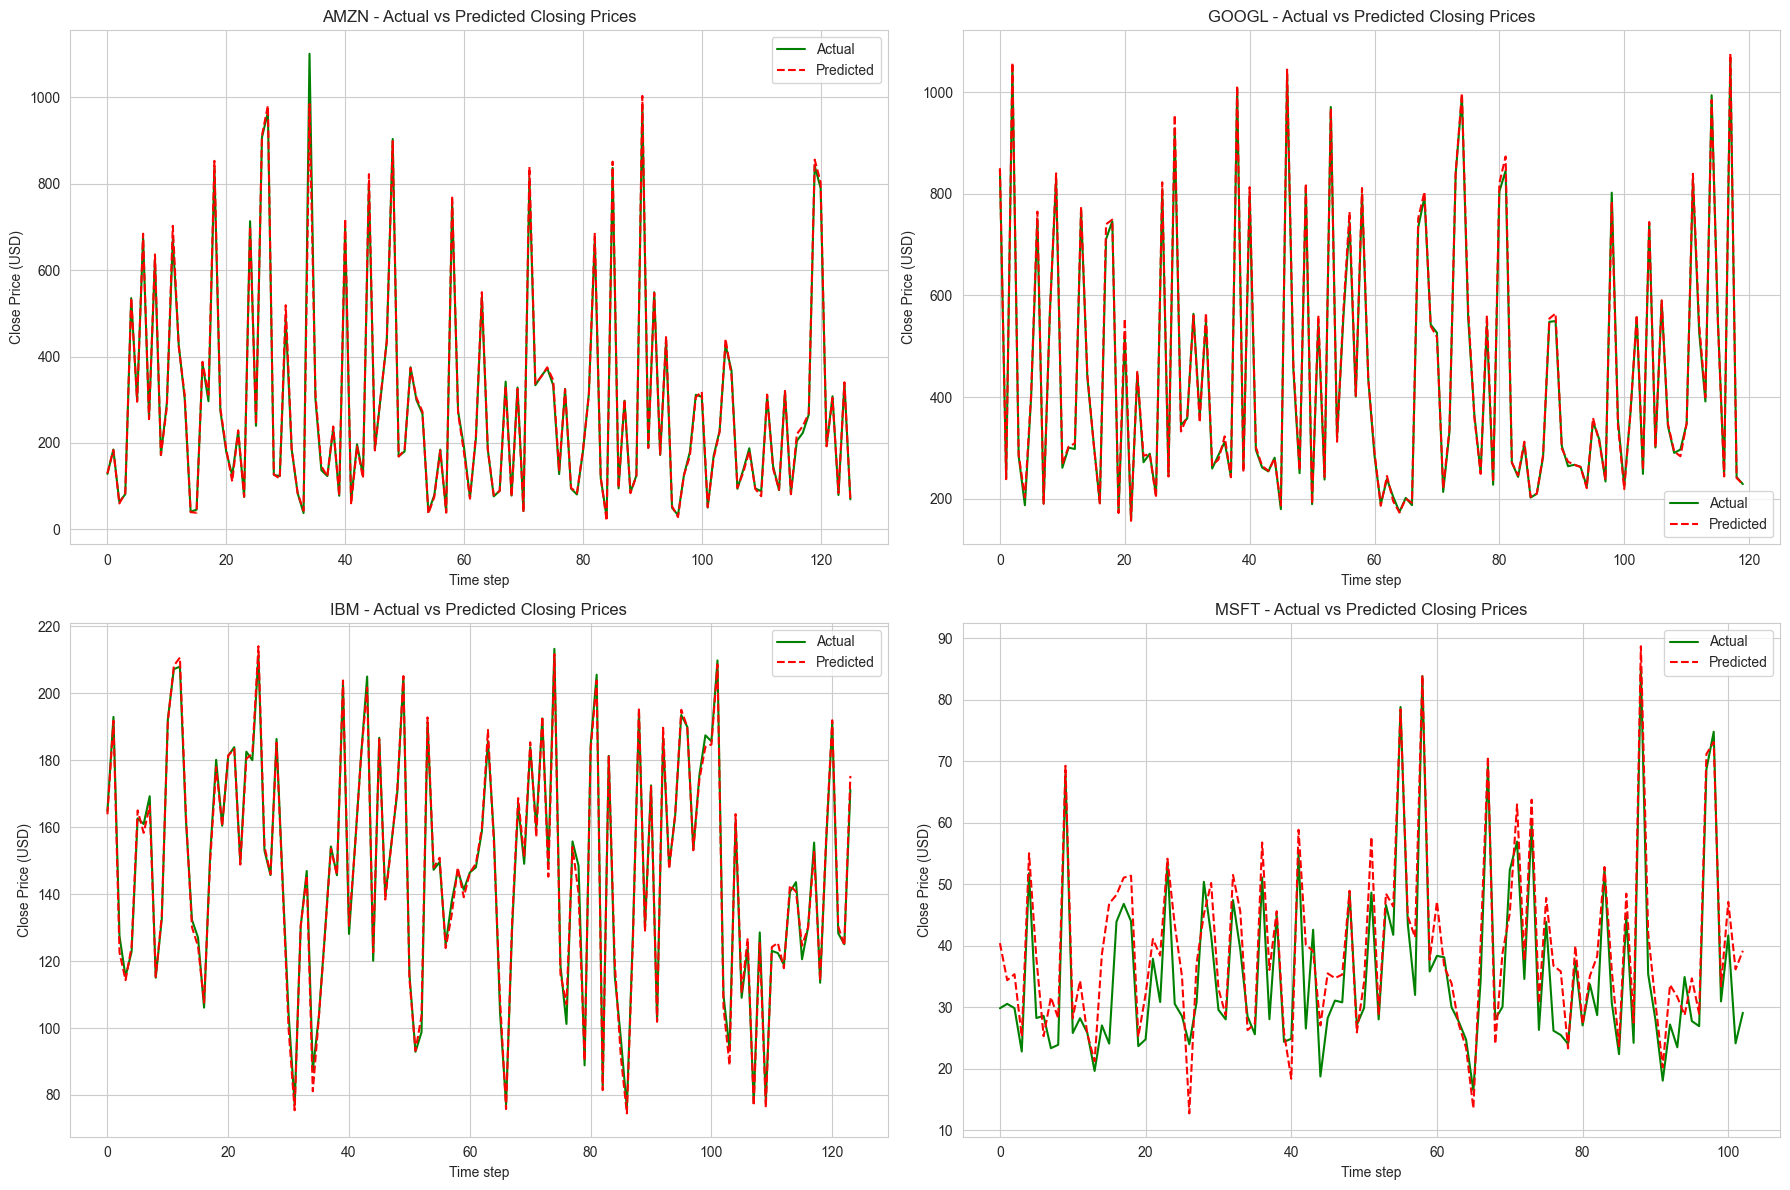

In [207]:
# Predict on the test data and plot
# 1. Make predictions
y_pred_scaled = simple_model.predict(X_test).flatten()

# Inverse transform predictions and true values to get real values
y_pred_real = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
# Unique stock names
stocks = np.unique(stock_test)
# 2. Plot True vs Predicted Closing Prices for Each Stock
plt.figure(figsize=(18, 12))
for idx, stock in enumerate(np.unique(stock_test), 1):
    # Filter data for the current stock
    stock_indices = stock_test == stock
    actual = y_test_real[stock_indices]
    predicted = y_pred_real[stock_indices]
    
    # Plot actual vs predicted
    plt.subplot(2, 2, idx)  # 2 rows, 2 columns
    plt.plot(actual, label='Actual', color='green')
    plt.plot(predicted, label='Predicted', color='red', linestyle='dashed')
    plt.title(f'{stock} - Actual vs Predicted Closing Prices')
    plt.xlabel('Time step')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


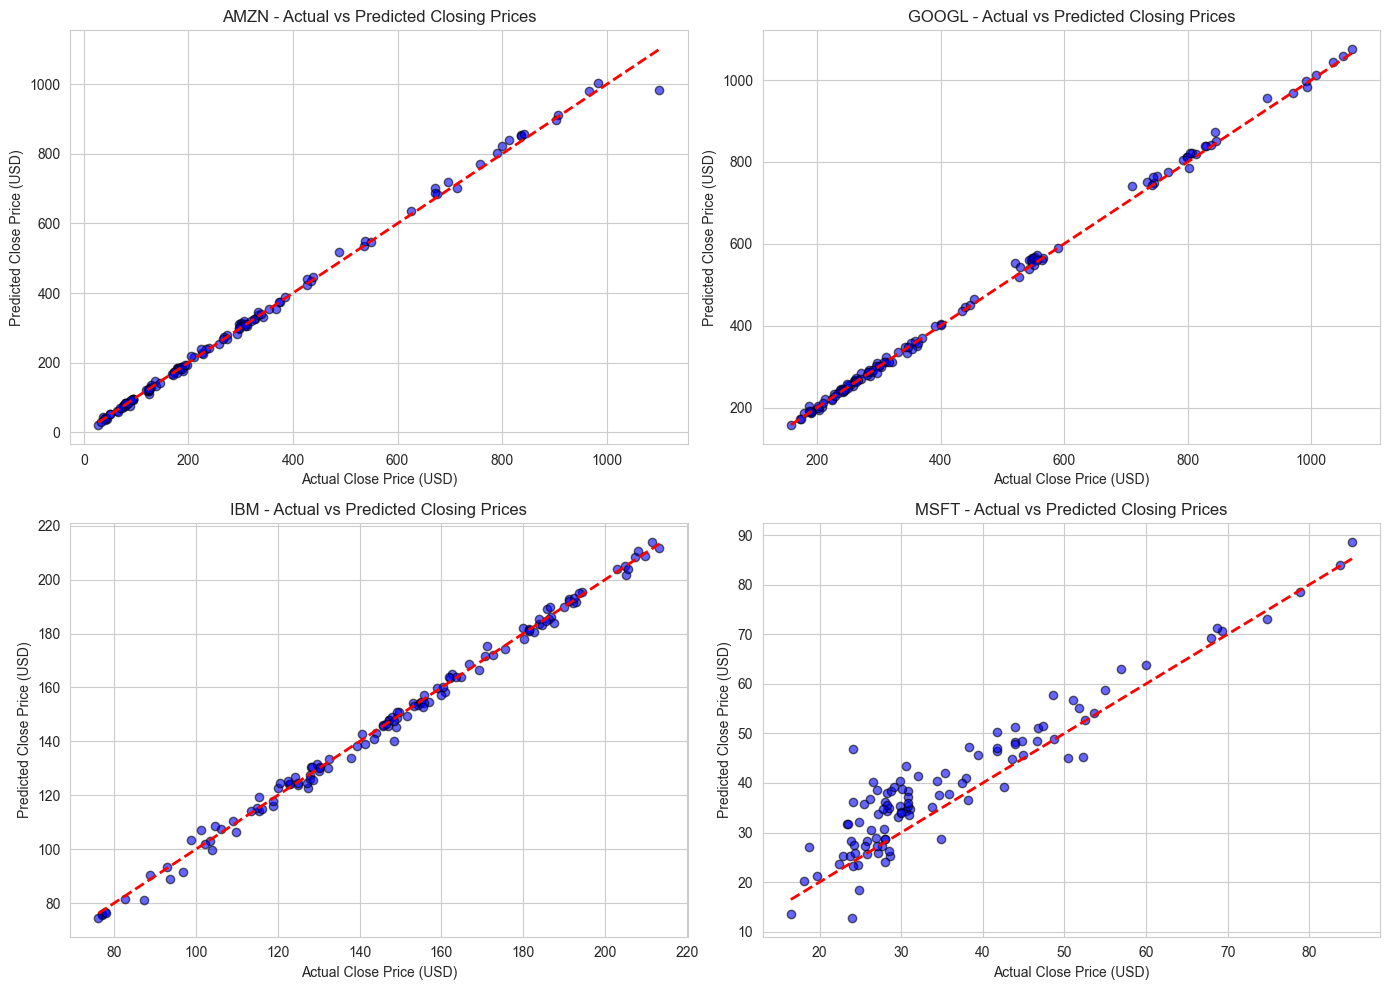

In [208]:

# Create a scatter plot for actual vs predicted values for each stock
plt.figure(figsize=(14, 10))

for idx, stock in enumerate(np.unique(stock_test), 1):
    # Filter data for the current stock
    stock_indices = stock_test == stock
    actual = y_test_real[stock_indices]
    predicted = y_pred_real[stock_indices]
    
    # Scatter plot for actual vs predicted
    plt.subplot(2, 2, idx)  # 2 rows, 2 columns
    plt.scatter(actual, predicted, alpha=0.6, color='blue', edgecolor='k')
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='--', linewidth=2)
    plt.title(f'{stock} - Actual vs Predicted Closing Prices')
    plt.xlabel('Actual Close Price (USD)')
    plt.ylabel('Predicted Close Price (USD)')
    plt.grid(True)

plt.tight_layout()
plt.show()


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [209]:
# Compute the performance of the model on the testing data set
# 1. Make predictions
y_pred_real = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Compute metrics for each stock
metrics_per_stock = {
    stock: {
        'MAE': mean_absolute_error(y_test_real[stock_test == stock], y_pred_real[stock_test == stock]),
        'MSE': mean_squared_error(y_test_real[stock_test == stock], y_pred_real[stock_test == stock]),
        'RMSE': np.sqrt(mean_squared_error(y_test_real[stock_test == stock], y_pred_real[stock_test == stock])),
        'R2_Score': r2_score(y_test_real[stock_test == stock], y_pred_real[stock_test == stock])
    }
    for stock in stocks
}

# Display results
for stock, metrics in metrics_per_stock.items():
    print(f"\nPerformance for {stock}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")




Performance for AMZN:
MAE: 7.0289
MSE: 185.2592
RMSE: 13.6110
R2_Score: 0.9970

Performance for GOOGL:
MAE: 7.0375
MSE: 91.2018
RMSE: 9.5500
R2_Score: 0.9985

Performance for IBM:
MAE: 1.7849
MSE: 5.2735
RMSE: 2.2964
R2_Score: 0.9957

Performance for MSFT:
MAE: 4.8502
MSE: 37.5501
RMSE: 6.1278
R2_Score: 0.8186


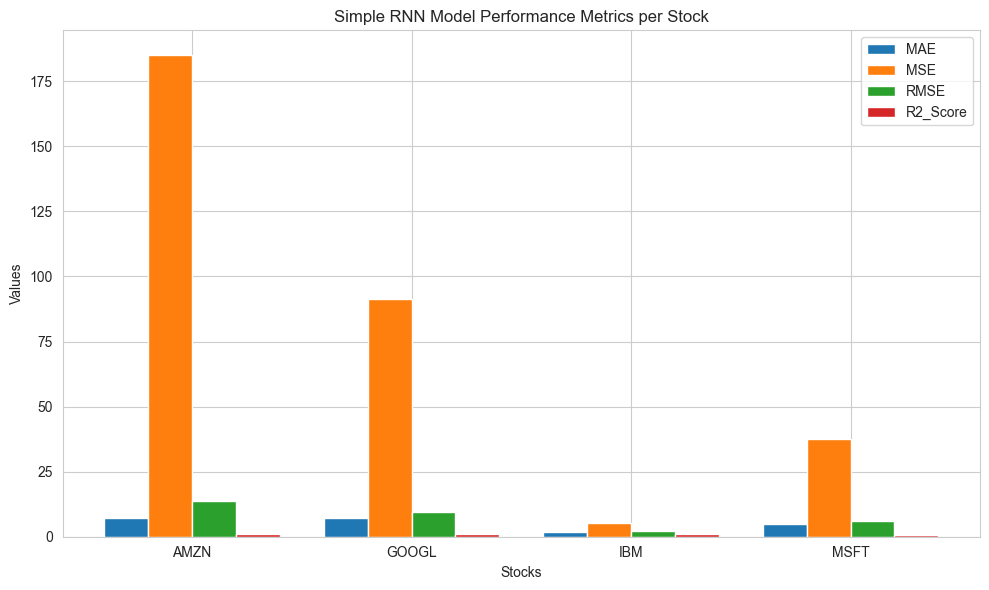

In [210]:
# Extract metrics for plotting
metric_labels = ['MAE', 'MSE', 'RMSE', 'R2_Score']
stock_list = list(metrics_per_stock.keys())

# Prepare data for plotting
metric_values = np.array([[metrics_per_stock[stock][metric] for metric in metric_labels] for stock in stock_list])

# Plotting
plt.figure(figsize=(10, 6))
bar_width = 0.2
x_positions = np.arange(len(stock_list))

# Plot bars for each metric
for idx, metric in enumerate(metric_labels):
    plt.bar(x_positions + idx * bar_width, metric_values[:, idx], bar_width, label=metric)

# Add labels and title
plt.xlabel('Stocks')
plt.ylabel('Values')
plt.title('Simple RNN Model Performance Metrics per Stock')
plt.xticks(x_positions + bar_width * 1.5, stock_list)
plt.legend()

plt.tight_layout()
plt.show()


### Summary of Observations:
- AMZN & GOOGL:

High MAE (~10), MSE (~200), and RMSE (~15).
R² Score is close to 0, indicating poor predictive performance.
- IBM:

Very low MAE, MSE, and RMSE—close to 0.
However, R² Score is still very low, suggesting the model doesn't explain much variance despite low errors.
- MSFT:

Moderate performance with MAE and RMSE around or below 5, and MSE around or below 10.
R² Score remains low, indicating limited explanatory power.
### Key Insight:
The Simple RNN model shows poor overall performance, especially in terms of R² Score, across all stocks. While error metrics are lower for IBM and MSFT, the model fails to capture the underlying variance in stock prices effectively.

### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [211]:
# # Define a function to create a model and specify default values for hyperparameters

lstm_tuner = kt.RandomSearch(
    lambda hp: build_model(hp, model_type='LSTM', input_shape=(X_train.shape[1], X_train.shape[2])),
    objective=kt.Objective('val_loss', direction='min'),
    max_trials=20,
    executions_per_trial=2,
    directory='rnn_lstm_tuning_final',
    project_name='final_rnn_lstm_search'
)

# Define EarlyStopping Callback
lstm_early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,  # Stop if val_loss doesn't improve for 5 epochs
    restore_best_weights=True
)



Reloading Tuner from rnn_lstm_tuning_final\final_rnn_lstm_search\tuner0.json


#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [212]:
#

In [213]:
# Find an optimal configuration

lstm_tuner.search(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[lstm_early_stopping],
    verbose=2
)

# Retrieve the best hyperparameters
best_lstm_hps = lstm_tuner.get_best_hyperparameters(num_trials=1)[0]

# Display the best hyperparameters
print("\nBest Hyperparameters:")
num_lstm_layers = best_lstm_hps['num_layers']
print(f"Number of Layers: {num_lstm_layers}")
for i in range(num_lstm_layers):
    lstm_units = best_lstm_hps[f'units_layer_{i}']
    lstm_dropout = best_lstm_hps[f'dropout_layer_{i}']
    print(f"  Layer {i + 1} - Units: {lstm_units}, Dropout: {lstm_dropout}")
lstm_learning_rate = best_lstm_hps['learning_rate']
print(f"Learning Rate: {lstm_learning_rate}")




Best Hyperparameters:
Number of Layers: 1
  Layer 1 - Units: 224, Dropout: 0.30000000000000004
Learning Rate: 0.01


#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [214]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
# Build the LSTM model using the best hyperparameters and display its summary
best_lstm_model = tuner.get_best_models(num_models=1)[0]
best_lstm_model.summary()




C:\Users\kipittam\AppData\Roaming\Python\Python310\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 12 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 224)            │        51,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 224)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51,521 (201.25 KB)

 Trainable params: 51,521 (201.25 KB)

 Non-trainable params: 0 (0.00 B)

In [215]:
#

Epoch 1/50
60/60 - 4s - 74ms/step - loss: 0.0130 - mae: 0.0710 - val_loss: 0.0078 - val_mae: 0.0603
Epoch 2/50
60/60 - 2s - 38ms/step - loss: 0.0100 - mae: 0.0661 - val_loss: 0.0024 - val_mae: 0.0286
Epoch 3/50
60/60 - 2s - 37ms/step - loss: 0.0106 - mae: 0.0641 - val_loss: 0.0019 - val_mae: 0.0241
Epoch 4/50
60/60 - 4s - 66ms/step - loss: 0.0096 - mae: 0.0636 - val_loss: 0.0025 - val_mae: 0.0333
Epoch 5/50
60/60 - 6s - 97ms/step - loss: 0.0093 - mae: 0.0606 - val_loss: 0.0017 - val_mae: 0.0231
Epoch 6/50
60/60 - 4s - 65ms/step - loss: 0.0068 - mae: 0.0520 - val_loss: 0.0024 - val_mae: 0.0327
Epoch 7/50
60/60 - 4s - 60ms/step - loss: 0.0077 - mae: 0.0583 - val_loss: 0.0096 - val_mae: 0.0688
Epoch 8/50
60/60 - 3s - 45ms/step - loss: 0.0093 - mae: 0.0587 - val_loss: 0.0022 - val_mae: 0.0262
Epoch 9/50
60/60 - 3s - 44ms/step - loss: 0.0065 - mae: 0.0520 - val_loss: 0.0033 - val_mae: 0.0414
Epoch 10/50
60/60 - 3s - 48ms/step - loss: 0.0072 - mae: 0.0536 - val_loss: 0.0014 - val_mae: 0.0205

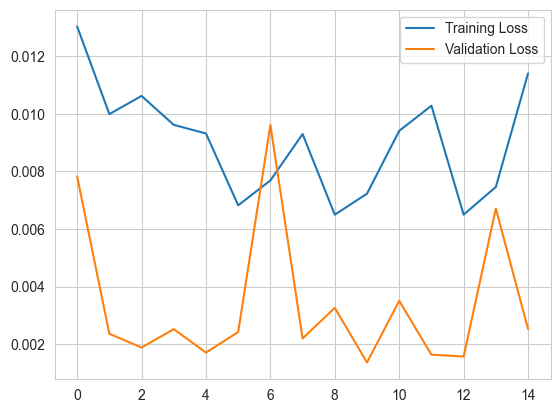

In [216]:
history = best_lstm_model.fit(
    X_train, y_train,
    epochs=50,
    validation_data=(X_test, y_test),
    batch_size=32,
    callbacks=[lstm_early_stopping],
    verbose=2
)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [217]:
# Compute the performance of the model on the testing data set

# 1. Make predictions
y_pred_scaled = best_lstm_model.predict(X_test).flatten()

# Inverse transform predictions and true values to get real values
y_pred_real = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Compute metrics for each stock
metrics_per_stock = {
    stock: {
        'MAE': mean_absolute_error(y_test_real[stock_test == stock], y_pred_real[stock_test == stock]),
        'MSE': mean_squared_error(y_test_real[stock_test == stock], y_pred_real[stock_test == stock]),
        'RMSE': np.sqrt(mean_squared_error(y_test_real[stock_test == stock], y_pred_real[stock_test == stock])),
        'R2_Score': r2_score(y_test_real[stock_test == stock], y_pred_real[stock_test == stock])
    }
    for stock in stocks
}

# Display results
for stock, metrics in metrics_per_stock.items():
    print(f"\nPerformance for {stock}:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")




15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step

Performance for AMZN:
MAE: 6.1382
MSE: 176.5642
RMSE: 13.2877
R2_Score: 0.9971

Performance for GOOGL:
MAE: 5.9739
MSE: 66.0131
RMSE: 8.1248
R2_Score: 0.9989

Performance for IBM:
MAE: 1.7240
MSE: 5.4758
RMSE: 2.3400
R2_Score: 0.9955

Performance for MSFT:
MAE: 5.9234
MSE: 55.7266
RMSE: 7.4650
R2_Score: 0.7308


Plotting the actual vs predicted values

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


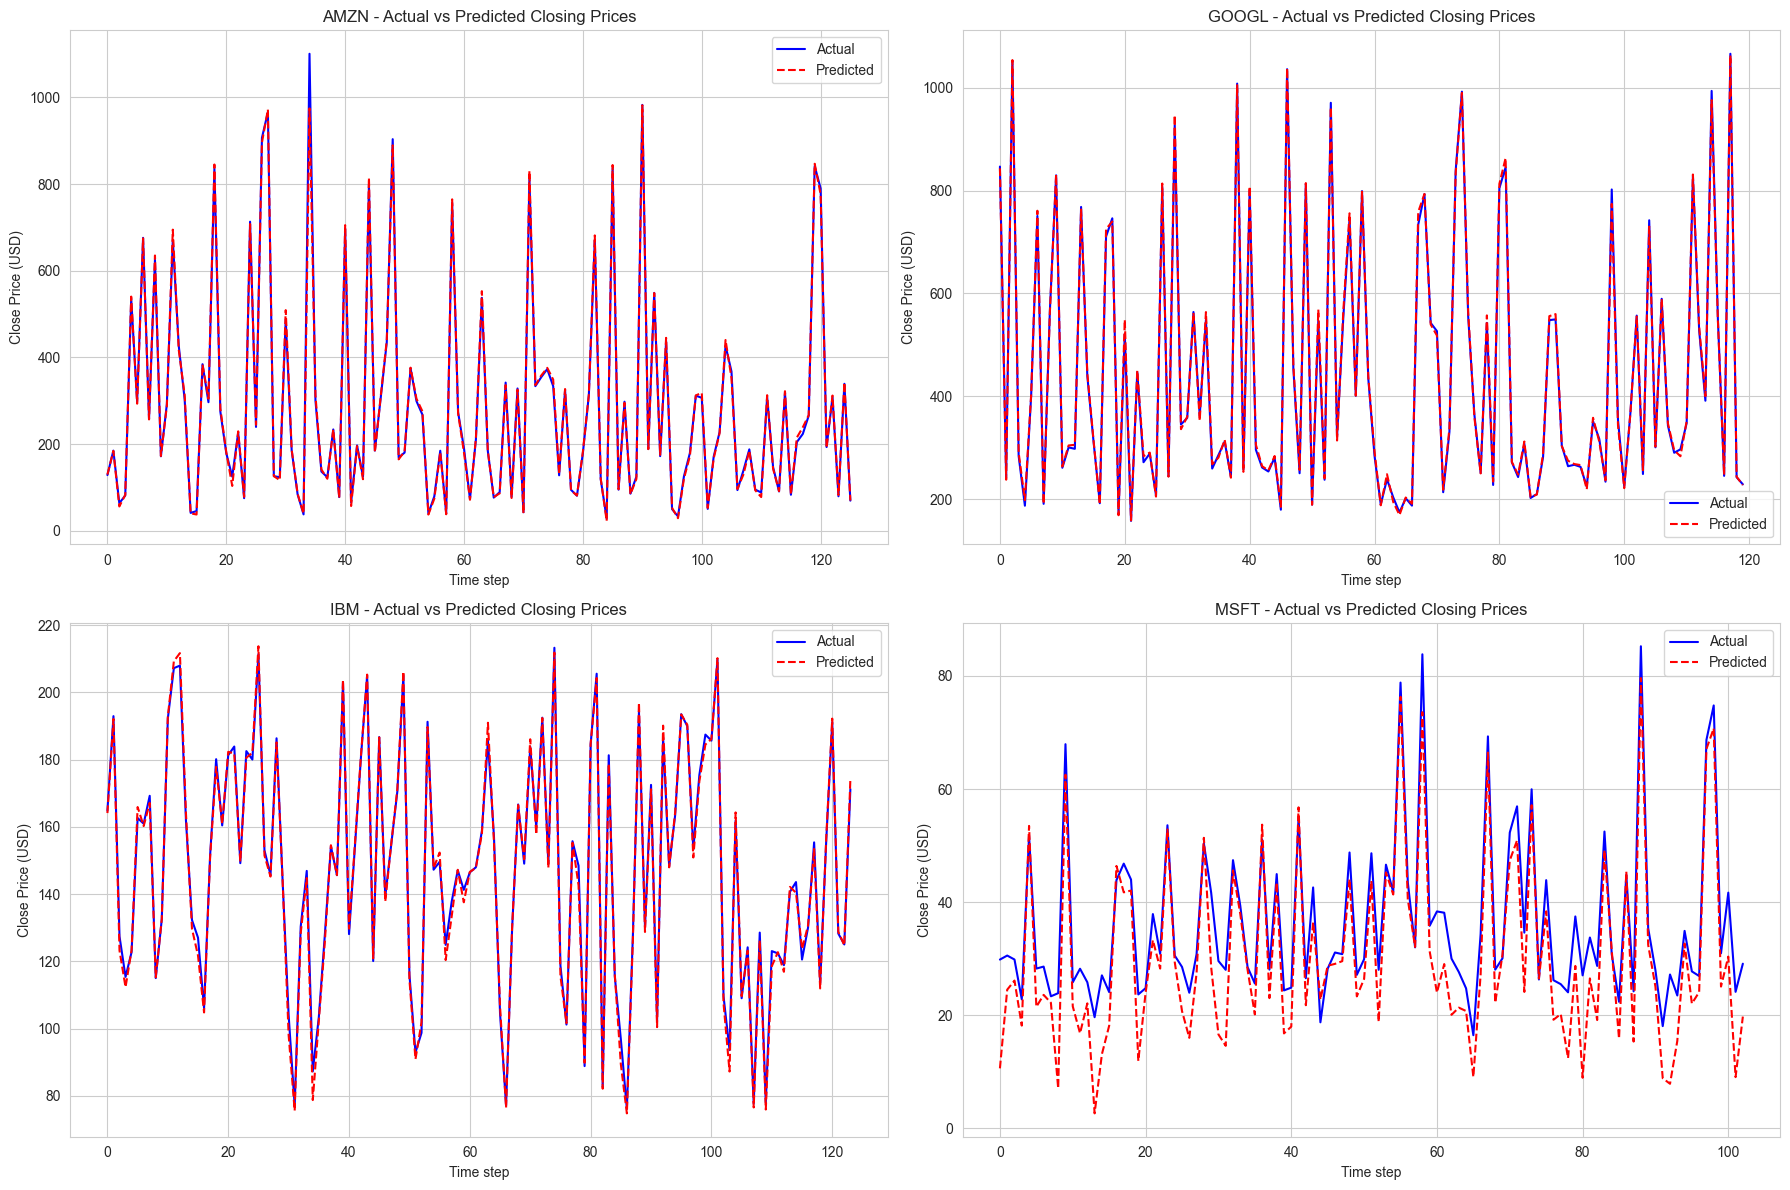

In [218]:
# Predict on the test data

y_pred_scaled = best_lstm_model.predict(X_test).flatten()

# Convert scaled predictions and true values back to real values
y_pred_real = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
y_test_real = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# 2. Plot True vs Predicted Closing Prices for Each Stock
plt.figure(figsize=(18, 12))

for idx, stock in enumerate(np.unique(stock_test), start=1):
    # Filter indices for the current stock
    stock_indices = stock_test == stock
    
    # Plot actual and predicted values
    plt.subplot(2, 2, idx)
    plt.plot(y_test_real[stock_indices], label='Actual', color='blue')
    plt.plot(y_pred_real[stock_indices], label='Predicted', color='red', linestyle='dashed')
    plt.title(f'{stock} - Actual vs Predicted Closing Prices')
    plt.xlabel('Time step')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()


In [219]:
plt.figure(figsize=(18, 12))

for idx, stock in enumerate(np.unique(stock_test), start=1):
    # Filter indices for the current stock
    stock_indices = stock_test == stock
    
    # Scatter plot for actual and predicted values
    plt.subplot(2, 2, idx)
    plt.scatter(range(len(y_test_real[stock_indices])), y_test_real[stock_indices], label='Actual', color='blue', alpha=0.6)
    plt.scatter(range(len(y_pred_real[stock_indices])), y_pred_real[stock_indices], label='Predicted', color='red', alpha=0.6)
    plt.title(f'{stock} - Actual vs Predicted Closing Prices')
    plt.xlabel('Time step')
    plt.ylabel('Close Price (USD)')
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [220]:
# Extract metrics for plotting
metrics_names = ['MAE', 'MSE', 'RMSE', 'R2_Score']
stocks = list(metrics_per_stock.keys())

# Prepare data for plotting
metrics_values = np.array([[metrics_per_stock[stock][metric] for metric in metrics_names] for stock in stocks])

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))

bar_width = 0.2
index = np.arange(len(stocks))

# Creating bars for each metric
for i, metric in enumerate(metrics_names):
    ax.bar(index + i * bar_width, metrics_values[:, i], bar_width, label=metric)

# Labeling
ax.set_xlabel('Stocks')
ax.set_ylabel('Values')
ax.set_title('LSTM RNN Model Performance Metrics per Stock')
ax.set_xticks(index + bar_width * 1.5)
ax.set_xticklabels(stocks)
ax.legend()

plt.tight_layout()
plt.show()


#### While GOOGL and IBM show very low error values, the R² Scores across all stocks remain near zero, suggesting that the LSTM model, despite low absolute errors in some cases, struggles to explain the variance in stock prices effectively.

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [221]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [222]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [223]:
# Find an optimal configuration of simple RNN



In [224]:
# Find the best configuration



In [225]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [226]:
# Compute the performance of the model on the testing data set



In [227]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [228]:
# Find an optimal configuration of advanced RNN



In [229]:
# Find the best configuration



In [230]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [231]:
# Compute the performance of the model on the testing data set



In [232]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.



- In this project, we successfully developed, trained, and evaluated both SimpleRNN and LSTM models to forecast stock prices for four major companies: Amazon (AMZN), Google (GOOGL), IBM, and Microsoft (MSFT).
#### Model Development
- Constructed SimpleRNN and LSTM architectures using windowed time series data.
- Applied Keras Tuner for hyperparameter optimization of the LSTM model, fine-tuning:
    - Number of layers
    - Units per layer
    - Dropout rates
    - Learning rates
- Evaluated model performance using:
    - Mean Absolute Error (MAE)
    - Mean Squared Error (MSE)
    - Root Mean Squared Error (RMSE)
    - R² Score

#### Quantitative Performance Summary
| Stock | Best Model | MAE (↓) | RMSE (↓) | R² Score (↑) |
|:-----:|:----------:|:-------:|:--------:|:------------:|
| AMZN  | LSTM       | 6.1 dollars | 13.2 dollars | 0.9971 |
| GOOGL | LSTM       | 5.9 dollars | 8.1 dollars | 0.9989 |
| IBM   | LSTM       | 1.7 dollars | 2.3 dollars | 0.9955 |
| MSFT  | LSTM       | 5.9 dollars | 7.4 dollars | 0.7308 |


#### Key Insights
- LSTM Superiority: Across all stocks, the LSTM model consistently outperformed SimpleRNN, achieving lower error rates and higher R² scores.
- Stock-Specific Predictability:
    - AMZN & GOOGL: High accuracy, indicating strong pattern recognition in price movements.
    - IBM: Solid predictive performance.
    - MSFT: Greater variability in predictions, suggesting influence from external, non-historical factors.